# Quantum Fourier Transform :

In [1]:
"""
Quantum Fourier Transform Benchmark Program - Qiskit
"""

import math
import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *
import matplotlib.pyplot as plt
np.random.seed(0)

# Noise parameters
options = { } #if Noise is None

options_noisy = { #if Noise is not None
    'plot': False,
    "thermal_factor": 0.0,
    'show_partition': False,
    "decoherence_factor": 0.9,
    "depolarization_factor": 0.9,
    "bell_depolarization_factor": 0.9,
    "decay_factor": 0.9,
    "rotation_error": {'rx':[1.0, 0.0], 'ry':[1.0, 0.0], 'rz':[1.0, 0.0]},
    "tsp_model_error": [1.0, 0.0],
}

# Selection of basis gate set for transpilation
# Note: selector 1 is a hardware agnostic gate set
basis_selector = 1
basis_gates_array = [
    [],
    ['rx', 'ry', 'rz', 'cx'],       # a common basis set, default
    ['cx', 'rz', 'sx', 'x'],        # IBM default basis set
    ['rx', 'ry', 'rxx'],            # IonQ default basis set
    ['h', 'p', 'cx'],               # another common basis set
    ['u', 'cx']                     # general unitaries basis gates
]

verbose = False

# saved circuits for display
num_gates = 0
depth = 0
QC_ = None
QFT_ = None
QFTI_ = None

In [2]:
############### Circuit Definition

def QuantumFourierTransform (num_qubits, secret_int, method=1):
    global num_gates, depth
    # Size of input is one less than available qubits
    input_size = num_qubits
    num_gates = 0
    depth = 0
    
    # allocate qubits
    qr = QuantumRegister(num_qubits); cr = ClassicalRegister(num_qubits);
    qc = QuantumCircuit(qr, cr, name=f"qft({method})-{num_qubits}-{secret_int}")

    if method==1:

        # Perform X on each qubit that matches a bit in secret string
        s = ('{0:0'+str(input_size)+'b}').format(secret_int)
        for i_qubit in range(input_size):
            if s[input_size-1-i_qubit]=='1':
                qc.x(qr[i_qubit])
                num_gates += 1

        depth += 1

        qc.barrier()

        # perform QFT on the input
        qc.append(qft_gate(input_size).to_instruction(), qr)

        # End with Hadamard on all qubits (to measure the z rotations)
        ''' don't do this unless NOT doing the inverse afterwards
        for i_qubit in range(input_size):
             qc.h(qr[i_qubit])

        qc.barrier()'''
        

        qc.barrier()
        
        # some compilers recognize the QFT and IQFT in series and collapse them to identity;
        # perform a set of rotations to add one to the secret_int to avoid this collapse
        for i_q in range(0, num_qubits):
            divisor = 2 ** (i_q)
            qc.rz( 1 * math.pi / divisor , qr[i_q])
            num_gates+=1
        
        qc.barrier()

        # to revert back to initial state, apply inverse QFT
        qc.append(inv_qft_gate(input_size).to_instruction(), qr)

        qc.barrier()

    elif method == 2:

        for i_q in range(0, num_qubits):
            qc.h(qr[i_q])
            num_gates += 1

        for i_q in range(0, num_qubits):
            divisor = 2 ** (i_q)
            qc.rz(secret_int * math.pi / divisor, qr[i_q])
            num_gates += 1

        depth += 1

        qc.append(inv_qft_gate(input_size).to_instruction(), qr)

    # This method is a work in progress
    elif method==3:

        for i_q in range(0, secret_int):
            qc.h(qr[i_q])
            num_gates+=1

        for i_q in range(secret_int, num_qubits):
            qc.x(qr[i_q])
            num_gates+=1
            
        depth += 1
        
        qc.append(inv_qft_gate(input_size).to_instruction(), qr)
        
    else:
        exit("Invalid QFT method")

    # measure all qubits
    qc.measure(qr, cr)#,basis="Ensemble", add_param ="Z")
    num_gates += num_qubits
    depth += 1

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or num_qubits <= 5:
        if num_qubits < 9: QC_ = qc
        
    # return a handle on the circuit
    return qc

In [3]:
############### QFT Circuit

def qft_gate(input_size):
    global QFT_, num_gates, depth
    qr = QuantumRegister(input_size); qc = QuantumCircuit(qr, name="qft")
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in range(0, input_size):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in range(0, num_crzs):
                divisor = 2 ** (num_crzs - j)
                qc.crz( math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                num_gates += 1
                depth += 1
            
        # followed by an H gate (applied to all qubits)
        qc.h(qr[hidx])
        num_gates += 1
        depth += 1
        
        qc.barrier()
    
    if QFT_ == None or input_size <= 5:
        if input_size < 9: QFT_ = qc
        
    return qc

############### Inverse QFT Circuit

def inv_qft_gate(input_size):
    global QFTI_, num_gates, depth
    qr = QuantumRegister(input_size); qc = QuantumCircuit(qr, name="inv_qft")
    
    # Generate multiple groups of diminishing angle CRZs and H gate
    for i_qubit in reversed(range(0, input_size)):
    
        # start laying out gates from highest order qubit (the hidx)
        hidx = input_size - i_qubit - 1
        
        # precede with an H gate (applied to all qubits)
        qc.h(qr[hidx])
        num_gates += 1
        depth += 1
        
        # if not the highest order qubit, add multiple controlled RZs of decreasing angle
        if hidx < input_size - 1:   
            num_crzs = i_qubit
            for j in reversed(range(0, num_crzs)):
                divisor = 2 ** (num_crzs - j)
                qc.crz( -math.pi / divisor , qr[hidx], qr[input_size - j - 1])
                num_gates += 1
                depth += 1
            
        qc.barrier()  
    
    if QFTI_ == None or input_size <= 5:
        if input_size < 9: QFTI_= qc
        
    return qc

In [4]:
############################################
# DATA ANALYSIS - FIDELITY CALCULATIONS

## Uniform distribution function commonly used
def rescale_fidelity(fidelity, floor_fidelity, new_floor_fidelity):
    """
    Linearly rescales our fidelities to allow comparisons of fidelities across benchmarks
    
    fidelity: raw fidelity to rescale
    floor_fidelity: threshold fidelity which is equivalent to random guessing
    new_floor_fidelity: what we rescale the floor_fidelity to 

    Ex, with floor_fidelity = 0.25, new_floor_fidelity = 0.0:
        1 -> 1;
        0.25 -> 0;
        0.5 -> 0.3333;
    """
    rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
    
    # ensure fidelity is within bounds (0, 1)
    if rescaled_fidelity < 0:
        rescaled_fidelity = 0.0
    if rescaled_fidelity > 1:
        rescaled_fidelity = 1.0
    
    return rescaled_fidelity
    
def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist                

### Analysis methods to be expanded and eventually compiled into a separate analysis.py file
import math, functools

def hellinger_fidelity_with_expected(p, q):
    """ p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    if q_sum == 0:
        print("ERROR: polarization_fidelity(), expected distribution is invalid, all counts equal to 0")
        return 0

    p_normed = {}
    for key, val in p.items():
        p_normed[key] = val/p_sum
        # if p_sum != 0:
        #     p_normed[key] = val/p_sum
        # else:
        #     p_normed[key] = 0

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    
    # in some situations (error mitigation) this can go negative, use abs value
    if total < 0:
        print(f"WARNING: using absolute value in fidelity calculation")
        total = abs(total)
        
    dist = np.sqrt(total)/np.sqrt(2)
    fidelity = (1-dist**2)**2

    return fidelity

def polarization_fidelity(counts, correct_dist, thermal_dist=None):
    """
    Combines Hellinger fidelity and polarization rescaling into fidelity calculation
    used in every benchmark

    counts: the measurement outcomes after `num_shots` algorithm runs
    correct_dist: the distribution we expect to get for the algorithm running perfectly
    thermal_dist: optional distribution to pass in distribution from a uniform
                  superposition over all states. If `None`: generated as 
                  `uniform_dist` with the same qubits as in `counts`
                  
    returns both polarization fidelity and the hellinger fidelity

    Polarization from: `https://arxiv.org/abs/2008.11294v1`
    """
    #print("in polarization fidelity:",correct_dist)
    num_measured_qubits = len(list(correct_dist.keys())[0])
    print(num_measured_qubits)
    
    counts = {k.zfill(num_measured_qubits): v for k, v in counts.items()}
    
    # calculate hellinger fidelity between measured expectation values and correct distribution
    hf_fidelity = hellinger_fidelity_with_expected(counts,correct_dist)
    
    # to limit cpu and memory utilization, skip noise correction if more than 16 measured qubits
    if num_measured_qubits > 16:
        return { 'fidelity':hf_fidelity, 'hf_fidelity':hf_fidelity }

    # if not provided, generate thermal dist based on number of qubits
    if thermal_dist == None:
        thermal_dist = uniform_dist(num_measured_qubits)

    # set our fidelity rescaling value as the hellinger fidelity for a depolarized state
    floor_fidelity = hellinger_fidelity_with_expected(thermal_dist, correct_dist)

    # rescale fidelity result so uniform superposition (random guessing) returns fidelity
    # rescaled to 0 to provide a better measure of success of the algorithm (polarization)
    new_floor_fidelity = 0
    fidelity = rescale_fidelity(hf_fidelity, floor_fidelity, new_floor_fidelity)

    return { 'fidelity':fidelity, 'hf_fidelity':hf_fidelity }



In [5]:
# Define expected distribution calculated from applying the iqft to the prepared secret_int state
def expected_dist(num_qubits, secret_int, counts):
    dist = {}
    s = num_qubits - secret_int
    for key in counts.keys():
        if key[(num_qubits-secret_int):] == ''.zfill(secret_int):
            dist[key] = 1/(2**s)
    print("dist ====",dist)
    return dist

In [6]:
# Function to calculate circuit depth
def calculate_circuit_depth(qc):
    # Calculate the depth of the circuit
    depth = qc.depth()
    return depth

def calculate_transpiled_depth(qc,basis_selector):
    # use either the backend or one of the basis gate sets
    if basis_selector == 0:
        qc = transpile(qc, backend)
        
    else:
        basis_gates = basis_gates_array[basis_selector]
        qc = transpile(qc, basis_gates=basis_gates, seed_transpiler=0)
    transpiled_depth = qc.depth()
    return transpiled_depth

def plot_data(fidelity_data, Hf_fidelity_data, title):
    avg_fidelity_means = []
    avg_Hf_fidelity_means = []
    avg_num_qubits_values = list(fidelity_data.keys())
    print("avg_num_qubits_values",avg_num_qubits_values)
    # Calculate the average fidelity and Hamming fidelity for each unique number of qubits
    for num_qubits in avg_num_qubits_values:
        avg_fidelity = np.average(fidelity_data[num_qubits])
        avg_fidelity_means.append(avg_fidelity)

        avg_Hf_fidelity = np.mean(Hf_fidelity_data[num_qubits])
        avg_Hf_fidelity_means.append(avg_Hf_fidelity)
    
    

    # Plot the data
    x = np.arange(len(avg_num_qubits_values))
    
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects2 =ax.bar(x, avg_Hf_fidelity_means, width=0.4, label='Hellinger Fidelity',color="magenta")
    rects1 = ax.bar(x, avg_fidelity_means, width=0.2, label='Normalized Fidelity', color="blue")
    
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel('Average Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(avg_num_qubits_values)
    ax.legend()
    
    # Add labels to the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.5f}'.format(height),  # Formatting to two decimal places
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.show()
    print(fidelity_data)
    print(Hf_fidelity_data)
    print(avg_fidelity_means)
    print(avg_Hf_fidelity_means)

num_qubits =  2
s_range =  [2 3 1]
************
Executing [3] circuits with num_qubits = 2
s_int =  2
qc of 2 qubits of type <class 'type'>
      ┌───┐ ░ ┌──────┐ ░ ┌─────────┐ ░ ┌──────────┐ ░    ┌─┐
q0_0: ┤ X ├─░─┤1     ├─░─┤ Rz(π/2) ├─░─┤1         ├─░────┤M├
      └───┘ ░ │  qft │ ░ └┬───────┬┘ ░ │  inv_qft │ ░ ┌─┐└╥┘
q0_1: ──────░─┤0     ├─░──┤ Rz(π) ├──░─┤0         ├─░─┤M├─╫─
            ░ └──────┘ ░  └───────┘  ░ └──────────┘ ░ └╥┘ ║ 
c0: 2/═════════════════════════════════════════════════╩══╩═
                                                       1  0 
ExperimentResult(shots=0, success=True, meas_level=2, data=ExperimentResultData(partial_probability={'00': 0.0, '01': 0.0, '10': 0.0, '11': 1.0}, coeffmatrix=[ 0.25  0.    0.   -0.25  0.    0.    0.    0.    0.    0.    0.    0.
 -0.25  0.    0.    0.25], densitymatrix=[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]), header=QobjExperimentHeader(clbit_la

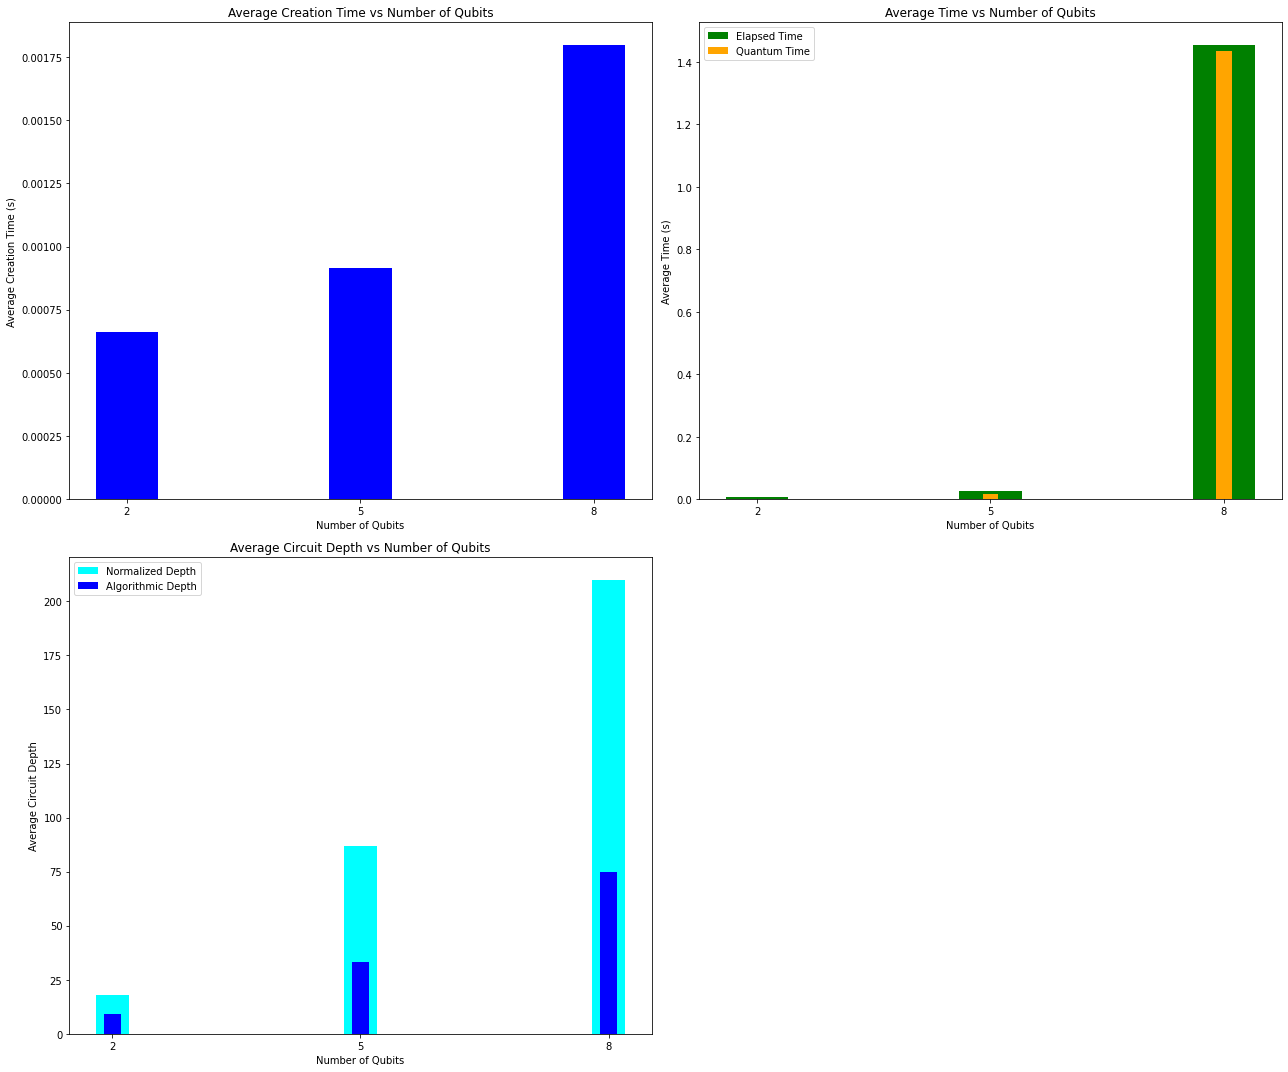

avg_num_qubits_values [2, 5, 8]


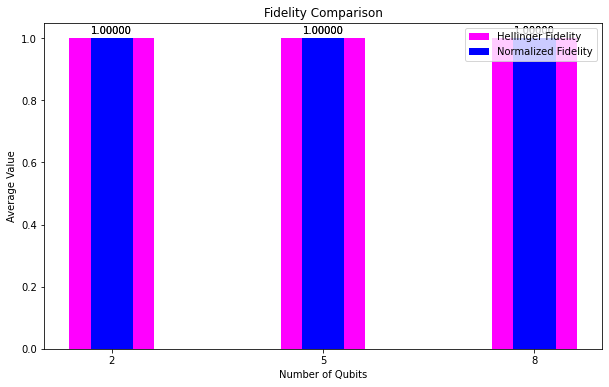

{2: [1.0, 1.0, 1.0], 5: [1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0]}
{2: [1.0, 1.0, 1.0], 5: [1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0]}
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]


In [7]:
from qiskit.circuit.library import QFT
import matplotlib
backend = BasicAer.get_backend('dm_simulator')
def run (min_qubits = 2, max_qubits = 8, max_circuits = 3, skip_qubits=3, num_shots = 100,method=1):
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    skip_qubits = max(1, skip_qubits)
    global max_ckts
    max_ckts = max_circuits

    global min_qbits,max_qbits,skp_qubits

    min_qbits = min_qubits
    max_qbits = max_qubits
    skp_qubits = skip_qubits

    creation_times = []
    elapsed_times = []
    quantum_times = []
    circuit_depths = []
    transpiled_depths = []
    fidelity_data = {}
    Hf_fidelity_data = {}

    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for input_size in range(min_qubits, max_qubits + 1, skip_qubits):
        
        # reset random seed 
        np.random.seed(0)
        num_qubits = input_size
        print("num_qubits = ",num_qubits)
        fidelity_data[num_qubits] = []
        Hf_fidelity_data[num_qubits] = []
        # determine number of circuits to execute for this group
        # and determine range of secret strings to loop over
        if method == 1 or method == 2:
            num_circuits = min(2 ** (input_size), max_circuits)
            if 2**(input_size) <= max_circuits:
                s_range = list(range(num_circuits))
            else:
                s_range = np.random.choice(2**(input_size), num_circuits, False)
                print("s_range = ",s_range)
         
        elif method == 3:
            num_circuits = min(input_size, max_circuits)

            if input_size <= max_circuits:
                s_range = list(range(num_circuits))
            else:
                s_range = np.random.choice(range(input_size), num_circuits, False)
        
        else:
            sys.exit("Invalid QFT method")

        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            print("s_int = ",s_int)
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = QuantumFourierTransform(num_qubits, s_int, method=method).reverse_bits()
            #creation time
            creation_time = time.time() - ts
            creation_times.append(creation_time)
            print(f"qc of {num_qubits} qubits of type {type}")
            print(qc)

            # collapse the sub-circuits used in this benchmark (for qiskit)
            qc = qc.decompose()

            # Calculate circuit depth
            depth = calculate_circuit_depth(qc)
            circuit_depths.append(depth)

            # Calculate transpiled circuit depth
            transpiled_depth = calculate_transpiled_depth(qc,basis_selector)
            transpiled_depths.append(transpiled_depth)
            
            #execution
            ts = time.time()
            job = execute(qc, backend, shots=num_shots, **options)
            result = job.result()
            elapsed_time = time.time() - ts
            elapsed_times.append(elapsed_time)

            # Calculate quantum processing time (excluding creation time)
            quantum_time = result.results[0].running_time_taken
            quantum_times.append(quantum_time)
            print(result.results[0])
            #ensemble probability
            prob = result.results[0].data.partial_probability
            print(prob)
            counts = prob

            for key in counts.keys():
               counts[key] = int(counts[key] * num_shots)
            print("counts=",counts)

            secret_int = int(s_int)
            print("secret_int = ",secret_int)
            # For method 1, expected result is always the secret_int
            if method==1:
                # add one to the secret_int to compensate for the extra rotations done between QFT and IQFT
                secret_int_plus_one = (secret_int + 1) % (2 ** num_qubits)
        
                # create the key that is expected to have all the measurements (for this circuit)
                key = format(secret_int_plus_one, f"0{num_qubits}b")
        
                # correct distribution is measuring the key 100% of the time
                correct_dist = {key: 1.0}
                print("correct_dist =",correct_dist)
        
            # For method 2, expected result is always the secret_int
            elif method==2:
        
                # create the key that is expected to have all the measurements (for this circuit)
                key = format(secret_int, f"0{num_qubits}b")
        
                # correct distribution is measuring the key 100% of the time
                correct_dist = {key: 1.0}
                print("correct_dist =",correct_dist)
    
            # For method 3, correct_dist is a distribution with more than one value
            elif method==3:
        
                # correct_dist is from the expected dist
                correct_dist = expected_dist(num_qubits, secret_int, counts)
                
            #fidelity
            fidelity_dict = polarization_fidelity(counts, correct_dist)
            print("fidelity_dict =",fidelity_dict)
            
            fidelity_data[num_qubits].append(fidelity_dict['fidelity'])
            Hf_fidelity_data[num_qubits].append(fidelity_dict['hf_fidelity'])
        
        print(f"... number of gates, depth = {num_gates}, {depth}")
        
        # Wait for some active circuits to complete; report metrics when groups complete
        #ex.throttle_execution(metrics.finalize_group)

    # Wait for all active circuits to complete; report metrics when groups complete
    #ex.finalize_execution(metrics.finalize_group)
    
    ##########
    
    # print a sample circuit created (if not too large)
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    if method==1:
        print("\nQFT Circuit ="); print(QFT_)
    print("\nInverse QFT Circuit ="); print(QFTI_)

    return creation_times, elapsed_times, quantum_times, circuit_depths, transpiled_depths, fidelity_data, Hf_fidelity_data

# Execute the benchmark program, accumulate metrics, and calculate circuit depths
creation_times, elapsed_times, quantum_times, circuit_depths,transpiled_depths, fidelity_data, Hf_fidelity_data = run()
    
# Define the range of qubits for the x-axis
num_qubits_range = range(min_qbits, max_qbits+1,skp_qubits)
print("num_qubits_range =",num_qubits_range)

# Calculate average creation time, elapsed time, quantum processing time, and circuit depth for each number of qubits
avg_creation_times = [np.mean(creation_times[i:i+max_ckts]) for i in range(0, len(creation_times), max_ckts)]
avg_elapsed_times = [np.mean(elapsed_times[i:i+max_ckts]) for i in range(0, len(elapsed_times), max_ckts)]
avg_quantum_times = [np.mean(quantum_times[i:i+max_ckts]) for i in range(0, len(quantum_times), max_ckts)]
avg_circuit_depths = [np.mean(circuit_depths[i:i+max_ckts]) for i in range(0, len(circuit_depths), max_ckts)]
avg_transpiled_depths = [np.mean(transpiled_depths[i:i+max_ckts]) for i in range(0, len(transpiled_depths), max_ckts)]

print(f"avg_creation_times={avg_creation_times}")
# Plot histograms for average creation time, average elapsed time, average quantum processing time, and average circuit depth versus the number of qubits
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_creation_times, color='blue')
plt.xlabel('Number of Qubits')
plt.ylabel('Average Creation Time (s)')
plt.title('Average Creation Time vs Number of Qubits')

plt.subplot(2, 2, 2)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_elapsed_times, color='green',label ='Elapsed Time')
plt.bar(num_qubits_range, avg_quantum_times, color='orange',label ='Quantum Time', width=0.2)
plt.xlabel('Number of Qubits')
plt.ylabel('Average Time (s)')
plt.title('Average Time vs Number of Qubits')
plt.legend()

plt.subplot(2, 2, 3)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_transpiled_depths, color='cyan', label='Normalized Depth', width=0.4)  # Adjust width here
plt.bar(num_qubits_range, avg_circuit_depths, color='blue', label='Algorithmic Depth', width=0.2)  # Adjust width here
plt.xlabel('Number of Qubits')
plt.ylabel('Average Circuit Depth')
plt.title('Average Circuit Depth vs Number of Qubits')
plt.legend()


plt.tight_layout()
plt.show()

# Calculate the fidelity data
plot_data(fidelity_data, Hf_fidelity_data, "Fidelity Comparison")